In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Reshape, Conv2DTranspose, MaxPooling2D, UpSampling2D, LeakyReLU
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

In [2]:
(ds_train, ds_test_), ds_info = tfds.load('mnist',
                                         split=['test', 'test'],
                                         shuffle_files=True,
                                         as_supervised=True,
                                         with_info=True)

In [3]:
batch_size = 256

In [4]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = image/255.
    return image, image

In [5]:
ds_train = ds_train.map(preprocess).cache().shuffle(ds_info.splits['train'].num_examples).batch(batch_size)
ds_test = ds_test_.map(preprocess).batch(batch_size).cache().prefetch(batch_size)

In [6]:
# return label for testing

def preprocess_with_label(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.math.round(image/255.)
    return image, label

In [7]:
ds_test_label = ds_test_.map(preprocess_with_label).batch(1000)

In [8]:
def Encoder(z_dim):
    inputs = layers.Input(shape=[28, 28, 1])
    
    x = inputs
    x = Conv2D(filters=8, kernel_size=(3,3), strides=2, padding='same', activation='relu')(x)
    x = Conv2D(filters=8, kernel_size=(3,3), strides=1, padding='same', activation='relu')(x)
    x = Conv2D(filters=8, kernel_size=(3,3), strides=2, padding='same', activation='relu')(x)
    x = Conv2D(filters=8, kernel_size=(3,3), strides=1, padding='same', activation='relu')(x)
    
    x = Flatten()(x)
    out = Dense(z_dim)(x)
    
    return Model(inputs=inputs, outputs=out, name='encoder')

In [9]:
def Decoder(z_dim):
    inputs = layers.Input(shape=[z_dim])
    x = inputs
    x = Dense(7*7*64, activation='relu')(x)
    x = Reshape((7,7,64))(x)
    
    x = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation='relu')(x)
    x = UpSampling2D((2,2))(x)
    
    x = Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', activation='relu')(x)
    x = UpSampling2D((2,2))(x)
    
    out = Conv2D(filters=1, kernel_size=(3,3), strides=1, padding='same', activation='sigmoid')(x)
    
    #return out
    return Model(inputs=inputs, outputs=out, name='decoder')

In [10]:
class Autoencoder():
    def __init__(self, z_dim):
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        
        model_input = self.encoder.input
        model_output = self.decoder(self.encoder.output)
        self.model = Model(model_input, model_output)

In [11]:
autoencoder = Autoencoder(z_dim=10)

In [12]:
autoencoder.encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 8)         80        
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         584       
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           584       
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 8)           584       
                                                                 
 flatten (Flatten)           (None, 392)               0         
                                                                 
 dense (Dense)               (None, 10)                3930

In [13]:
autoencoder.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_1 (Dense)             (None, 3136)              34496     
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 32)        18464     
                                                           

In [14]:
model_path = 'autoencoder.h5'

In [15]:
checkpoint = ModelCheckpoint(model_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='auto',
                             save_weights_only = False)

early = EarlyStopping(monitor='val_loss',
                      mode='auto',
                      patience=5)

callbacks_list = [checkpoint, early]

In [16]:
autoencoder.model.compile(
    loss = 'mse',
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=3e-4))
    #metrics=[tf.keras.losses.BianryCrossentropy()])

In [17]:
autoencoder.model.fit(ds_train, validation_data=ds_test,
                      epochs=100, callbacks=callbacks_list)

Epoch 1/100
40/40 [==============================] - ETA: 0s - loss: 0.1190
Epoch 1: val_loss improved from inf to 0.07139, saving model to autoencoder.h5
40/40 [==============================] - 5s 36ms/step - loss: 0.1190 - val_loss: 0.0714
Epoch 2/100
40/40 [==============================] - ETA: 0s - loss: 0.0687
Epoch 2: val_loss improved from 0.07139 to 0.06753, saving model to autoencoder.h5
40/40 [==============================] - 1s 13ms/step - loss: 0.0687 - val_loss: 0.0675
Epoch 3/100
37/40 [==========================>...] - ETA: 0s - loss: 0.0652
Epoch 3: val_loss improved from 0.06753 to 0.06089, saving model to autoencoder.h5
40/40 [==============================] - 1s 13ms/step - loss: 0.0649 - val_loss: 0.0609
Epoch 4/100
37/40 [==========================>...] - ETA: 0s - loss: 0.0572
Epoch 4: val_loss improved from 0.06089 to 0.05659, saving model to autoencoder.h5
40/40 [==============================] - 1s 14ms/step - loss: 0.0571 - val_loss: 0.0566
Epoch 5/100
39/4

In [18]:
images, labels = next(iter(ds_test))
autoencoder.model = load_model(model_path)
outputs = autoencoder.model.predict(images)

8/8 [==============================] - 0s 1ms/step


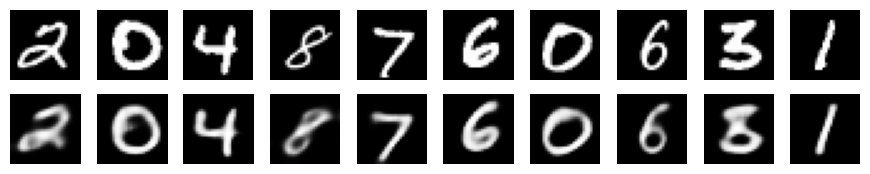

In [19]:
# Display
grid_col = 10
grid_row = 2

f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.1, grid_row))

i = 0
for row in range(0, grid_row, 2):
    for col in range(grid_col):
        axarr[row, col].imshow(images[i,:,:,0], cmap='gray')
        axarr[row, col].axis('off')
        axarr[row+1, col].imshow(outputs[i,:,:,0], cmap='gray')
        axarr[row+1, col].axis('off')
        i+=1
plt.show()

In [20]:
model_path_2 = 'autoencoder_100.h5'

In [21]:
autoencoder_100 = Autoencoder(z_dim=100)

In [22]:
checkpoint = ModelCheckpoint(model_path_2,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='auto',
                             save_weights_only = False)

early = EarlyStopping(monitor='val_loss',
                      mode='auto',
                      patience=5)

callbacks_list = [checkpoint, early]

In [23]:
autoencoder_100.model.compile(
    loss = 'mse',
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=3e-4))
    #metrics=[tf.keras.losses.BianryCrossentropy()])

In [24]:
autoencoder_100.model.fit(ds_train, validation_data=ds_test,
                      epochs=100, callbacks=callbacks_list)

Epoch 1/100
39/40 [============================>.] - ETA: 0s - loss: 0.1028
Epoch 1: val_loss improved from inf to 0.06933, saving model to autoencoder_100.h5
40/40 [==============================] - 1s 16ms/step - loss: 0.1027 - val_loss: 0.0693
Epoch 2/100
38/40 [===========================>..] - ETA: 0s - loss: 0.0638
Epoch 2: val_loss improved from 0.06933 to 0.05632, saving model to autoencoder_100.h5
40/40 [==============================] - 1s 13ms/step - loss: 0.0640 - val_loss: 0.0563
Epoch 3/100
37/40 [==========================>...] - ETA: 0s - loss: 0.0506
Epoch 3: val_loss did not improve from 0.05632
40/40 [==============================] - 1s 13ms/step - loss: 0.0502 - val_loss: 0.0605
Epoch 4/100
37/40 [==========================>...] - ETA: 0s - loss: 0.0407
Epoch 4: val_loss improved from 0.05632 to 0.03390, saving model to autoencoder_100.h5
40/40 [==============================] - 1s 14ms/step - loss: 0.0404 - val_loss: 0.0339
Epoch 5/100
38/40 [=====================

In [25]:
images, labels = next(iter(ds_test))
autoencoder_100.model = load_model(model_path_2)
outputs = autoencoder_100.model.predict(images)

8/8 [==============================] - 0s 2ms/step


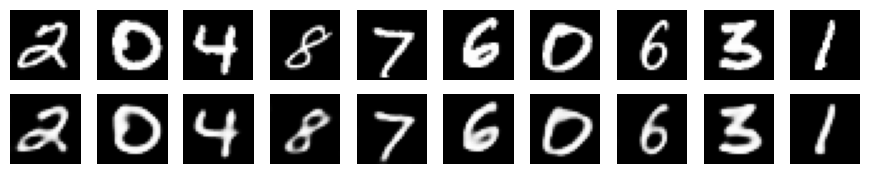

In [26]:
# Display
grid_col = 10
grid_row = 2

f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.1, grid_row))

i = 0
for row in range(0, grid_row, 2):
    for col in range(grid_col):
        axarr[row, col].imshow(images[i,:,:,0], cmap='gray')
        axarr[row, col].axis('off')
        axarr[row+1, col].imshow(outputs[i,:,:,0], cmap='gray')
        axarr[row+1, col].axis('off')
        i+=1
plt.show()

In [27]:
autoencoder_2 = Autoencoder(z_dim=2)

early = EarlyStopping(monitor='val_loss',
                      mode='auto',
                      patience=5)

callbacks_list = [early]

autoencoder_2.model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3))

autoencoder_2.model.fit(ds_train, validation_data=ds_test,
                        epochs = 50, callbacks = callbacks_list)

Epoch 1/50
40/40 [==============================] - 1s 15ms/step - loss: 0.0934 - val_loss: 0.0747
Epoch 2/50
40/40 [==============================] - 0s 11ms/step - loss: 0.0647 - val_loss: 0.0620
Epoch 3/50
40/40 [==============================] - 0s 12ms/step - loss: 0.0589 - val_loss: 0.0567
Epoch 4/50
40/40 [==============================] - 1s 12ms/step - loss: 0.0562 - val_loss: 0.0540
Epoch 5/50
40/40 [==============================] - 0s 12ms/step - loss: 0.0544 - val_loss: 0.0532
Epoch 6/50
40/40 [==============================] - 0s 11ms/step - loss: 0.0531 - val_loss: 0.0530
Epoch 7/50
40/40 [==============================] - 0s 12ms/step - loss: 0.0524 - val_loss: 0.0521
Epoch 8/50
40/40 [==============================] - 0s 11ms/step - loss: 0.0517 - val_loss: 0.0545
Epoch 9/50
40/40 [==============================] - 0s 12ms/step - loss: 0.0512 - val_loss: 0.0522
Epoch 10/50
40/40 [==============================] - 1s 13ms/step - loss: 0.0506 - val_loss: 0.0535
Epoch 11/

32/32 [==============================] - 0s 1ms/step


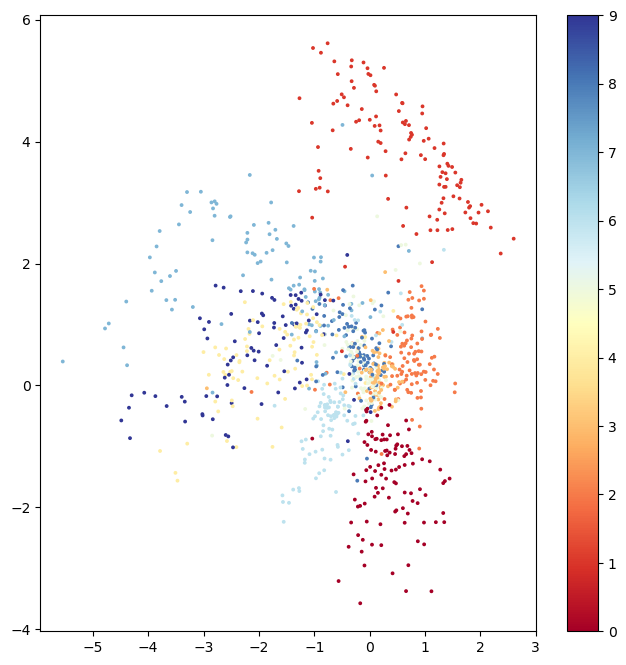

In [29]:
images, labels = next(iter(ds_test_label))
outputs = autoencoder_2.encoder.predict(images)
plt.figure(figsize=(8,8))
plt.scatter(outputs[:,0], outputs[:,1], c=labels, cmap='RdYlBu', s=3)
plt.colorbar()

4/4 [==============================] - 0s 50ms/step


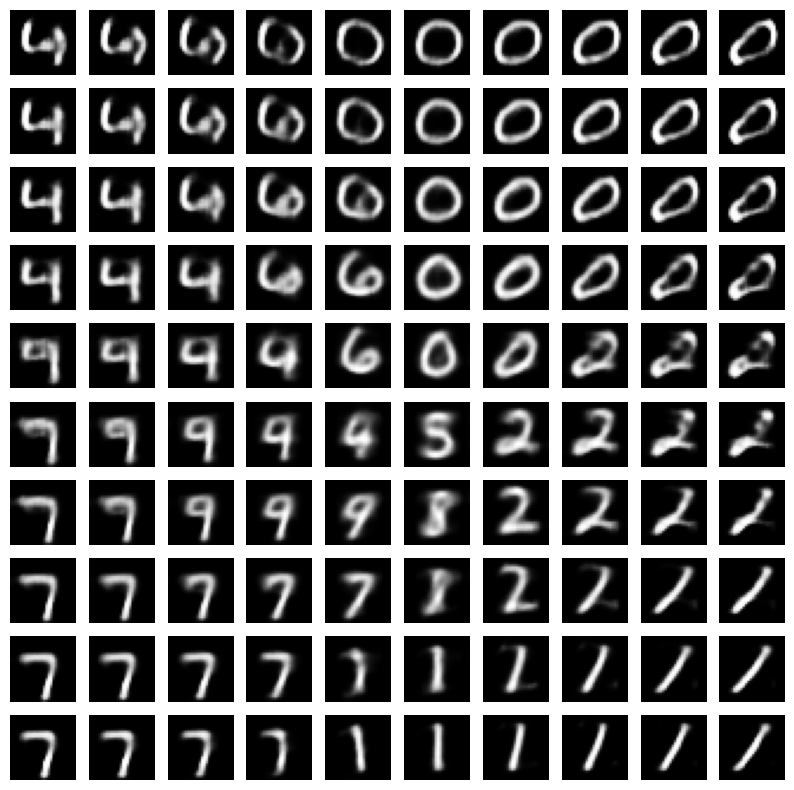

In [31]:
z_samples = np.array([[z1, z2] for z2 in np.arange(-5, 5, 1.) for z1 in np.arange(-5, 5, 1.)])
images = autoencoder_2.decoder.predict(z_samples)
grid_col = 10
grid_row = 10

f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col, grid_row))

i=0
for row in range(grid_row):
    for col in range(grid_col):
        axarr[row, col].imshow(images[i,:,:,0], cmap='gray')
        axarr[row, col].axis('off')
        i += 1
plt.show()

In [32]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [33]:
@interact
def explore_latent_variable(z1 = (-5,5,0.1),
                            z2 = (-5,5,0.1)):
    z_samples = [[z1, z2]]
    images = autoencoder_2.decoder.predict(z_samples)
    plt.figure(figsize=(2,2))
    plt.imshow(images[0,:,:,0], cmap='gray')

interactive(children=(FloatSlider(value=0.0, description='z1', max=5.0, min=-5.0), FloatSlider(value=0.0, desc…